In [1]:
import numpy as np
import os
import cv2
import glob 

## 輸入待校正圖片

In [2]:
# 待校正之左右影像

# ==== 兼容 OpenCV 讀中文路徑圖片 ====
def imread_unicode(file_path):
    ''' 讀取包含中文路徑的圖片，回傳 BGR np.ndarray  '''
    # 用 numpy 讀二進位，再用 OpenCV 解碼
    img_array = np.fromfile(file_path, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img
# ===================================

left_image_path = r"C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20251125_exp1_校正後圖片\court\origin_L.jpg"
right_image_path = r"C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20251125_exp1_校正後圖片\court\origin_R.jpg"

# 使用支援中文路徑的函數讀取圖片
left_img = imread_unicode(left_image_path)
right_img = imread_unicode(right_image_path)

# 檢查圖片是否成功讀取
if left_img is None:
    raise FileNotFoundError(f"無法讀取左側圖片: {left_image_path}")
if right_img is None:
    raise FileNotFoundError(f"無法讀取右側圖片: {right_image_path}")

width = left_img.shape[1]
height = left_img.shape[0]
image_size = (width, height)

print("image_size (w,h):", image_size)

image_size (w,h): (1920, 1080)


## 單目標定

In [3]:
def _calibration_single_camera(
    image_folder, 
    chessboard_size=(9, 6), 
    square_size=0.1, 
    save_path='calibration_result.npz',
    batch_size=50, 
    show_corners=False):

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) * square_size

    obj_points, img_points = [], []
    images = glob.glob(image_folder)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
        if ret:
            obj_points.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            img_points.append(corners2)
            if show_corners:
                cv2.drawChessboardCorners(img, chessboard_size, corners2, ret)
                cv2.imshow('Chessboard Corners', img)
                cv2.waitKey(100)
    if show_corners:
        cv2.destroyAllWindows()

    try:
        ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
            obj_points, img_points, gray.shape[::-1], None, None
        )
    except Exception:
        return None

    total_error = 0
    per_view_errors = []
    for i in range(len(obj_points)):
        projected_points, _ = cv2.projectPoints(obj_points[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
        projected_points = projected_points.reshape(-1, 2).astype(np.float32)
        img_pts = img_points[i].reshape(-1, 2).astype(np.float32)
        error = cv2.norm(img_pts, projected_points, cv2.NORM_L2) / len(projected_points)
        per_view_errors.append(error)
        total_error += error

    mean_reprojection_error = total_error / len(obj_points)
    fx, fy = camera_matrix[0, 0], camera_matrix[1, 1]
    cx, cy = camera_matrix[0, 2], camera_matrix[1, 2]
    focal_ratio = fx / fy
    k1, k2, p1, p2, k3 = dist_coeffs[0] if len(dist_coeffs[0]) >= 5 else (*dist_coeffs[0], 0)

    validation_results = {
        'mean_reprojection_error': mean_reprojection_error,
        'max_reprojection_error': max(per_view_errors),
        'min_reprojection_error': min(per_view_errors),
        'std_reprojection_error': np.std(per_view_errors),
        'per_view_errors': per_view_errors,
        'focal_lengths': (fx, fy),
        'principal_point': (cx, cy),
        'focal_ratio': focal_ratio,
        'distortion_coeffs': dist_coeffs[0].tolist()
    }

    np.savez(save_path, 
             camera_matrix=camera_matrix, 
             dist_coeffs=dist_coeffs, 
             rvecs=[],
             tvecs=[],
             validation_results=validation_results)

    return camera_matrix, dist_coeffs, [], [], validation_results

In [10]:
left_cam_with_validation = _calibration_single_camera(
    image_folder=r"C:\Users\f1410\Desktop\vicon_chessbord_img\20251125_chessboard_img\exp_1\left\single_optimized_15_1\*.jpg",
    chessboard_size=(9, 6), 
    square_size=0.1, 
    save_path='20251125_left_single_1_2.npz',  
    show_corners=False)

right_cam_with_validation = _calibration_single_camera(
    image_folder=r"C:\Users\f1410\Desktop\vicon_chessbord_img\20251125_chessboard_img\exp_1\right\single_optimized_15_1\*.jpg",
    chessboard_size=(9, 6), 
    square_size=0.1, 
    save_path='20251125_right_single_1_2.npz', 
    show_corners=False)

## 匯入單目校正參數

In [ ]:
# 從保存的文件中讀取驗證結果
def load_validation_results(npz_path):
    """
    從保存的npz文件中讀取驗證結果
    """
    data = np.load(npz_path, allow_pickle=True)
    
    if 'validation_results' in data:
        validation_results = data['validation_results'].item() 
        print(f"從 {npz_path} 讀取驗證結果:")
        print(f"平均重投影誤差: {validation_results['mean_reprojection_error']:.4f} 像素")
        print(f"最大重投影誤差: {validation_results['max_reprojection_error']:.4f} 像素")
        print(f"最小重投影誤差: {validation_results['min_reprojection_error']:.4f} 像素")
        print(f"標準差: {validation_results['std_reprojection_error']:.4f} 像素")
        print(f"焦距: fx={validation_results['focal_lengths'][0]:.2f}, fy={validation_results['focal_lengths'][1]:.2f}")
        print(f"主點: cx={validation_results['principal_point'][0]:.2f}, cy={validation_results['principal_point'][1]:.2f}")
        print(f"焦距比: {validation_results['focal_ratio']:.4f}")
        return validation_results
    else:
        print(f"文件 {npz_path} 中沒有驗證結果")
        return None

# 讀取並顯示驗證結果
print("=== 讀取左相機驗證結果 ===")
left_validation = load_validation_results('20251125_left_single_1_2.npz')

print("\n=== 讀取右相機驗證結果 ===")
right_validation = load_validation_results('20251125_right_single_1_2.npz')


=== 讀取左相機驗證結果 ===
從 20251125_left_single_1_2.npz 讀取驗證結果:
平均重投影誤差: 0.2034 像素
最大重投影誤差: 0.4863 像素
最小重投影誤差: 0.0995 像素
標準差: 0.1091 像素
焦距: fx=1375.81, fy=1369.16
主點: cx=920.67, cy=576.47
焦距比: 1.0049

=== 讀取右相機驗證結果 ===
從 20251125_right_single_1_2.npz 讀取驗證結果:
平均重投影誤差: 0.1448 像素
最大重投影誤差: 0.2617 像素
最小重投影誤差: 0.0693 像素
標準差: 0.0551 像素
焦距: fx=1312.85, fy=1302.94
主點: cx=934.08, cy=546.59
焦距比: 1.0076


In [4]:
left_data = np.load('./20251125_exp1_雙目參數檔/exp1/20251125_left_single_1_2.npz')
right_data = np.load('./20251125_exp1_雙目參數檔/exp1/20251125_right_single_1_2.npz')

mtxL = left_data['camera_matrix']
distL = left_data['dist_coeffs']

mtxR = right_data['camera_matrix']
distR = right_data['dist_coeffs']

print(mtxL)
print(distL)
print(mtxR)
print(distR)

[[1.37580860e+03 0.00000000e+00 9.20665482e+02]
 [0.00000000e+00 1.36916168e+03 5.76467288e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.44669935  0.28868046 -0.00245431  0.00171594 -0.10718427]]
[[1.31285239e+03 0.00000000e+00 9.34081049e+02]
 [0.00000000e+00 1.30294346e+03 5.46592299e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-4.29700141e-01  2.53579787e-01 -2.29406172e-04  1.92972492e-03
  -8.71064795e-02]]


## 畸變校正

In [26]:
import numpy as np
import cv2
# -------------------------- 畸變校正 ---------------------------------
def calibration(camera_matrix, dist_coeffs, un_cal_frame, w, h):
    # 計算新的相機矩陣
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 0, (w, h)) 

    # 矯正畸變
    dst = cv2.undistort(un_cal_frame, camera_matrix, dist_coeffs, None, new_camera_matrix)
    
    # 檢查 ROI 並裁剪圖像
    if roi is not None and all(roi):
        x, y, w, h = roi
        frame = dst[y:y+h, x:x+w]
        print(frame.shape)
    else:
        frame = dst  # 如果沒有有效 ROI，就用整張圖
    return frame

In [29]:
cam_param_L = np.load(r"C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20251125_left_single_1_2.npz", allow_pickle=True)
mtxL = cam_param_L['camera_matrix']
distL = cam_param_L['dist_coeffs']
img_L = calibration(mtxL, distL, left_img, width, height)
cv2.imwrite('undistorted_L.jpg', img_L)

cam_param_R = np.load(r"C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20251125_right_single_1_2.npz", allow_pickle=True)
mtxR = cam_param_R['camera_matrix']
distR = cam_param_R['dist_coeffs']
img_R = calibration(mtxR, distR, right_img, width, height)
cv2.imwrite('undistorted_R.jpg', img_R)

True

## 雙目標定

In [6]:
def _stereo_calibration(mtxL, mtxR, distL, distR, left_dir, right_dir):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5) 
    chessboard_size = (9, 6)
    square_size = 0.1 

    # 建立棋盤格世界座標點（ Z=0 ）
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    objp *= square_size

    # 讀取左右相機同一幀下的棋盤格圖片
    left_images = sorted(glob.glob(os.path.join(left_dir, '*.jpg')))
    right_images = sorted(glob.glob(os.path.join(right_dir, '*.jpg')))

    imgpoints_left = []  # 左相機圖片2D點
    imgpoints_right = [] # 右相機圖片2D點
    objpoints = []       # 棋盤格世界座標點

    # 初始化影像尺寸變數
    image_size = None

    for frameL, frameR in zip(left_images, right_images):
        img_left = cv2.imread(frameL)
        img_right = cv2.imread(frameR)

        grayL = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        grayR = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

        if image_size is None:
            image_size = grayL.shape[::-1] if grayL.shape[::-1] == grayR.shape[::-1] else None

        retL, cornersL = cv2.findChessboardCorners(grayL, chessboard_size, None)
        retR, cornersR = cv2.findChessboardCorners(grayR, chessboard_size, None)

        if retL and retR:
            cornersL = cv2.cornerSubPix(grayL, cornersL, (11, 11), (-1, -1), criteria)  # (11, 11) 是子像素搜索窗口大小，(-1, -1) 是停止迭代門檻值
            cornersR = cv2.cornerSubPix(grayR, cornersR, (11, 11), (-1, -1), criteria)

            cv2.drawChessboardCorners(img_left, chessboard_size, cornersL, retL)
            cv2.imshow('img_left', img_left)
            cv2.drawChessboardCorners(img_right, chessboard_size, cornersR, retR)
            cv2.imshow('img_right', img_right)
            cv2.waitKey(500)

            objpoints.append(objp)
            imgpoints_left.append(cornersL)
            imgpoints_right.append(cornersR)

    # 顯示結束後關閉視窗
    cv2.waitKey(1)
    cv2.destroyAllWindows()

    # 固定內參，僅估計 R, T 外參
    flags = cv2.CALIB_FIX_INTRINSIC
    # flags = cv2.CALIB_USE_INTRINSIC_GUESS # 初始化最佳相機內參
    
    ret, mtxL_opt, distL_opt, mtxR_opt, distR_opt, R, T, E, F = cv2.stereoCalibrate(
        objpoints, imgpoints_left, imgpoints_right,
        mtxL, distL, mtxR, distR,
        image_size, criteria=criteria, flags=flags)
    
    print(f"image_size: {image_size}")
    print(ret)  # ret 平均重投影誤差
    return mtxL_opt, distL_opt, mtxR_opt, distR_opt, R, T, ret

In [7]:
left_dir = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20251125_chessboard_img\exp_1\dual\left\stereo_selected_final"
right_dir = r"C:\Users\f1410\Desktop\vicon_chessbord_img\20251125_chessboard_img\exp_1\dual\right\stereo_selected_final"
mtxL_opt, distL_opt, mtxR_opt, distR_opt, R, T, ret = _stereo_calibration(mtxL, mtxR, distL, distR, left_dir, right_dir)

# 將 R, T 存成 npz檔
np.savez('stereo_rt_result_fix.npz', mtxL_opt=mtxL_opt, distL_opt=distL_opt, mtxR_opt=mtxR_opt, distR_opt=distR_opt, R=R, T=T, ret=ret)

image_size: (1920, 1080)
2.6055653004982906


## 匯入雙目校正參數

In [9]:
# 從 npz 檔案匯入 R, T
data = np.load('./20251125_exp1_雙目參數檔/exp1/stereo_rt_result_1_2.npz')
R = data['R']
T = data['T']

baseline = np.sqrt(T[0]**2 + T[1]**2 + T[2]**2)

from scipy.spatial.transform import Rotation as Rscipy

# 由R矩陣計算出沿X, Y, Z軸的旋轉角度（單位：度）
rot = Rscipy.from_matrix(R)
angles = rot.as_euler('xyz', degrees=True) 

print(f"R matrix:\n{R}\n")
print(f"T vector:\n{T}\n")
print(f"baseline: {baseline} m\n")
print(f"相機沿著X軸旋轉: {angles[0]:.2f} 度")
print(f"相機沿著Y軸旋轉: {angles[1]:.2f} 度")
print(f"相機沿著Z軸旋轉: {angles[2]:.2f} 度\n")

R matrix:
[[ 0.44448605 -0.28019813  0.85083557]
 [ 0.27341886  0.94693117  0.16900736]
 [-0.85303826  0.15751308  0.49750915]]

T vector:
[[-5.16834095]
 [-1.30534512]
 [ 2.79191185]]

baseline: [6.0175116] m

相機沿著X軸旋轉: 17.57 度
相機沿著Y軸旋轉: 58.54 度
相機沿著Z軸旋轉: 31.60 度



## VICON 內參、畸變係數資料

In [10]:
""" vicon exp1 資料 """

import numpy as np
from scipy.spatial.transform import Rotation as Rscipy

# Vicon data
# Left
left_pos = np.array([2973.50305869366, 5994.96740317049, 1655.47223912])
left_quat = np.array([0.189631759474656, 0.796071030590123, -0.535439280976936, 0.208843210185602])  # (x, y, z, w)

# Right
right_pos = np.array([-2938.09535167773, 5872.64767780364, 1741.91094986613])
right_quat = np.array([-0.226287253284064, 0.813675302925917, -0.519104252728115, -0.13136725318418])  # (x, y, z, w)

# 轉換 quaternion (x, y, z, w) to rotation matrix, using scipy
R_left = Rscipy.from_quat(left_quat).as_matrix()
R_right = Rscipy.from_quat(right_quat).as_matrix()

# 旋轉與平移皆為世界座標中的
# 計算從左相機轉到右相機的旋轉 R 和平移 T
R_rel = R_right.T @ R_left
T_rel = R_right.T @ (left_pos - right_pos)
baseline_m = np.linalg.norm(T_rel)/1000

print('Vicon Relative R (left->right):\n', R_rel)
print('Vicon Relative T (left->right):\n', T_rel)
print('Vicon baseline (m):', baseline_m)

Vicon Relative R (left->right):
 [[ 0.46724262 -0.88282684 -0.04796983]
 [ 0.87299265  0.4692621  -0.13295458]
 [ 0.1398863   0.02024473  0.98996059]]
Vicon Relative T (left->right):
 [-5169.29118267 -2871.45001027    51.31314361]
Vicon baseline (m): 5.913495542522613


## 立體校正

In [24]:
def _stereo_rectification(mtxL, distL, mtxR, distR, R, T, image_size):
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        mtxL, distL, mtxR, distR, image_size, R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=-1)
    return R1, R2, P1, P2, Q, roi1, roi2

R1, R2, P1, P2, Q, roi1, roi2 = _stereo_rectification(mtxL_opt, distL_opt, mtxR_opt, distR_opt, R, T, image_size)
np.savez('stereorectify_result_1_2_alp-1.npz', R1=R1, R2=R2, P1=P1, P2=P2, Q=Q, roi1=roi1, roi2=roi2)


In [25]:
data = np.load('./20251125_exp1_雙目參數檔/exp1/stereorectify_result_1_2_alp-1.npz')
roi1 = data['roi1']
roi2 = data['roi2']
print(roi1)
print(roi2)

[ 589    0 1331  852]
[   0    0 1098  835]


## 建立校正映射表

In [26]:
def _stereo_map(mtxL, distL, mtxR, distR, R1, R2, P1, P2, image_size):
    left_map_1, left_map_2 = cv2.initUndistortRectifyMap(
        mtxL, distL, R1, P1, image_size, cv2.CV_16SC2
        )
    right_map_1, right_map_2 = cv2.initUndistortRectifyMap(
        mtxR, distR, R2, P2, image_size, cv2.CV_16SC2
        )
    return left_map_1, left_map_2, right_map_1, right_map_2

left_map_1, left_map_2, right_map_1, right_map_2 = _stereo_map(mtxL_opt, distL_opt, mtxR_opt, distR_opt, R1, R2, P1, P2, image_size)
np.savez('stereomap_result_1_2_alp-1.npz', left_map_1=left_map_1, left_map_2=left_map_2, right_map_1=right_map_1, right_map_2=right_map_2)

## 校正影像

(np.float64(-0.5), np.float64(3839.5), np.float64(1079.5), np.float64(-0.5))

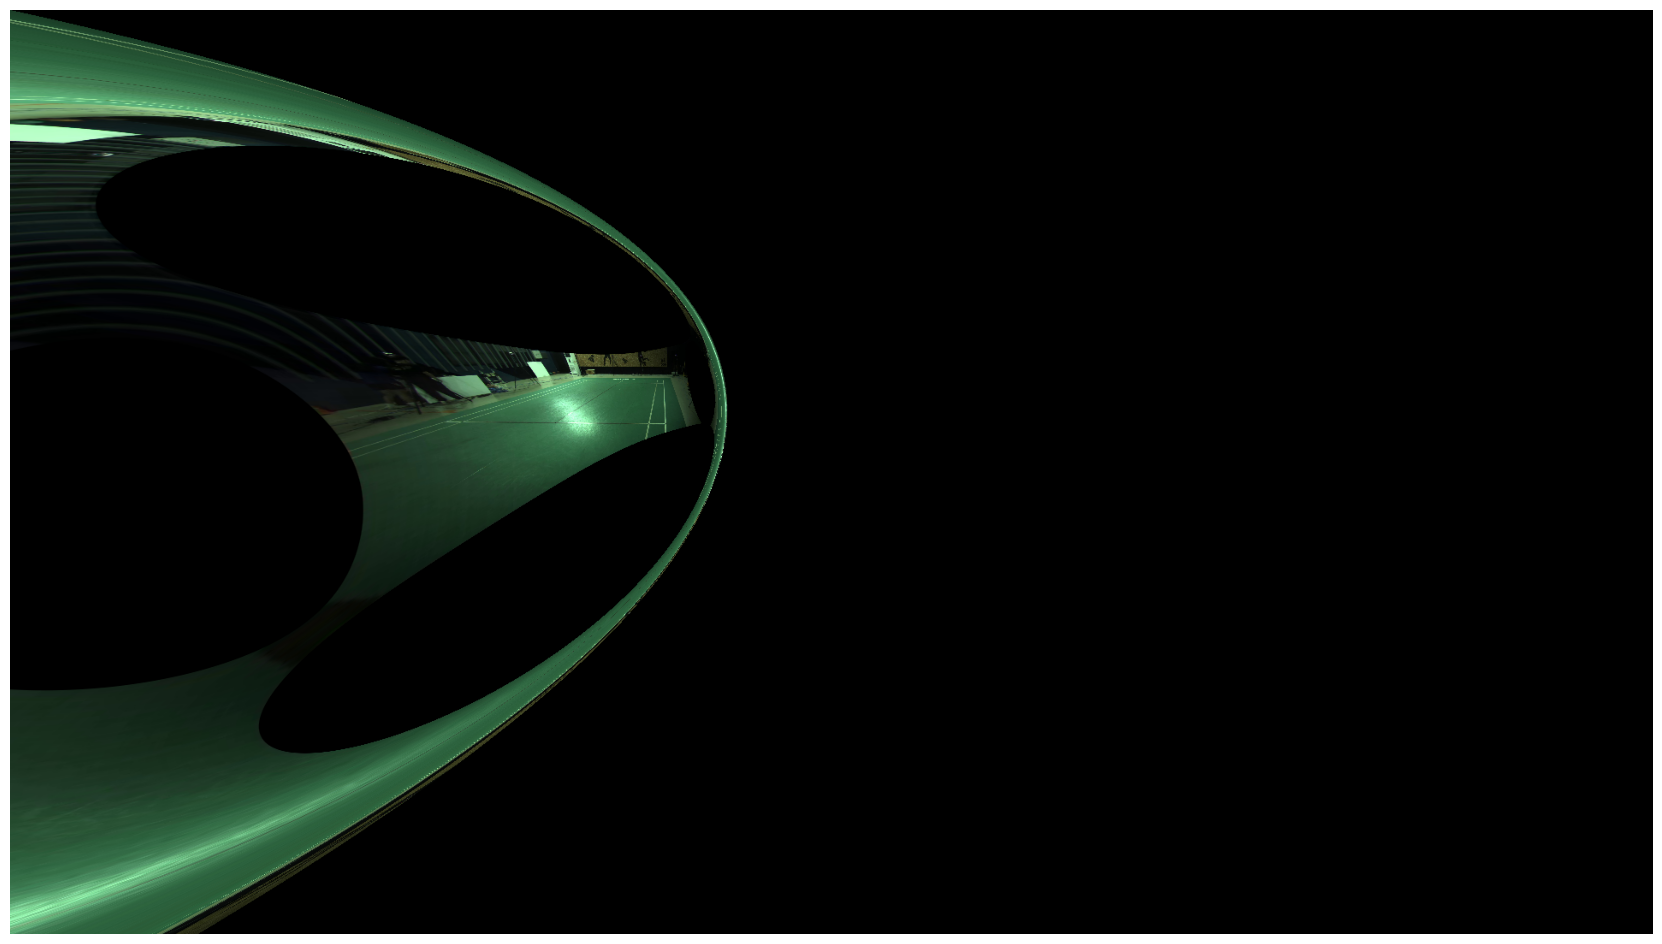

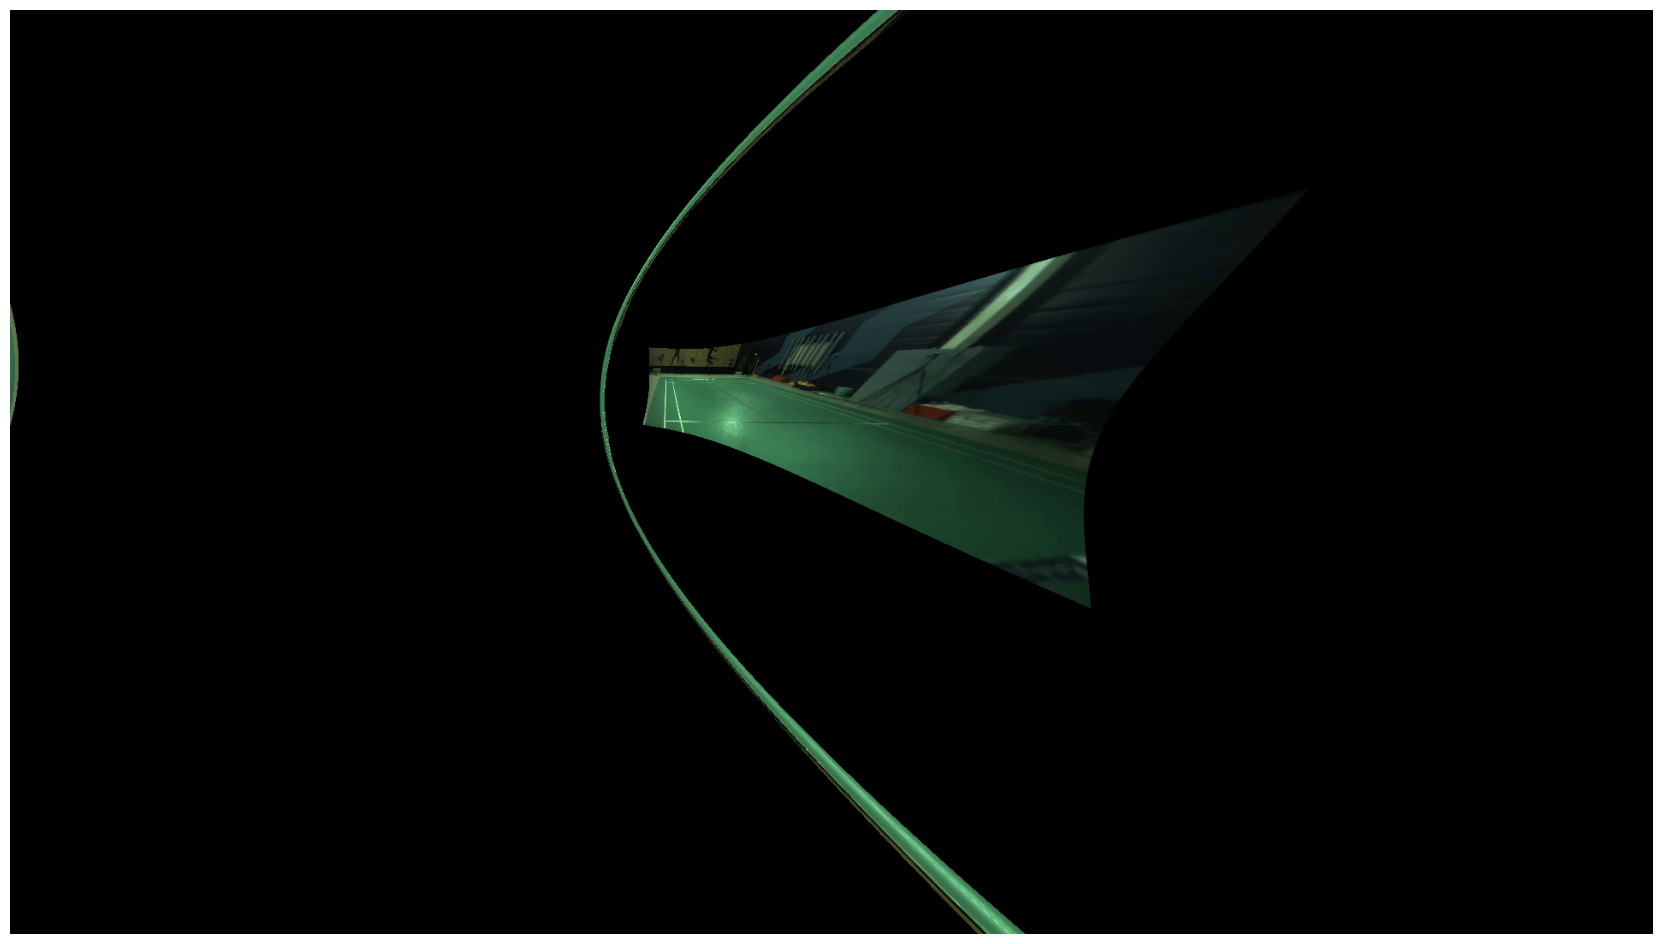

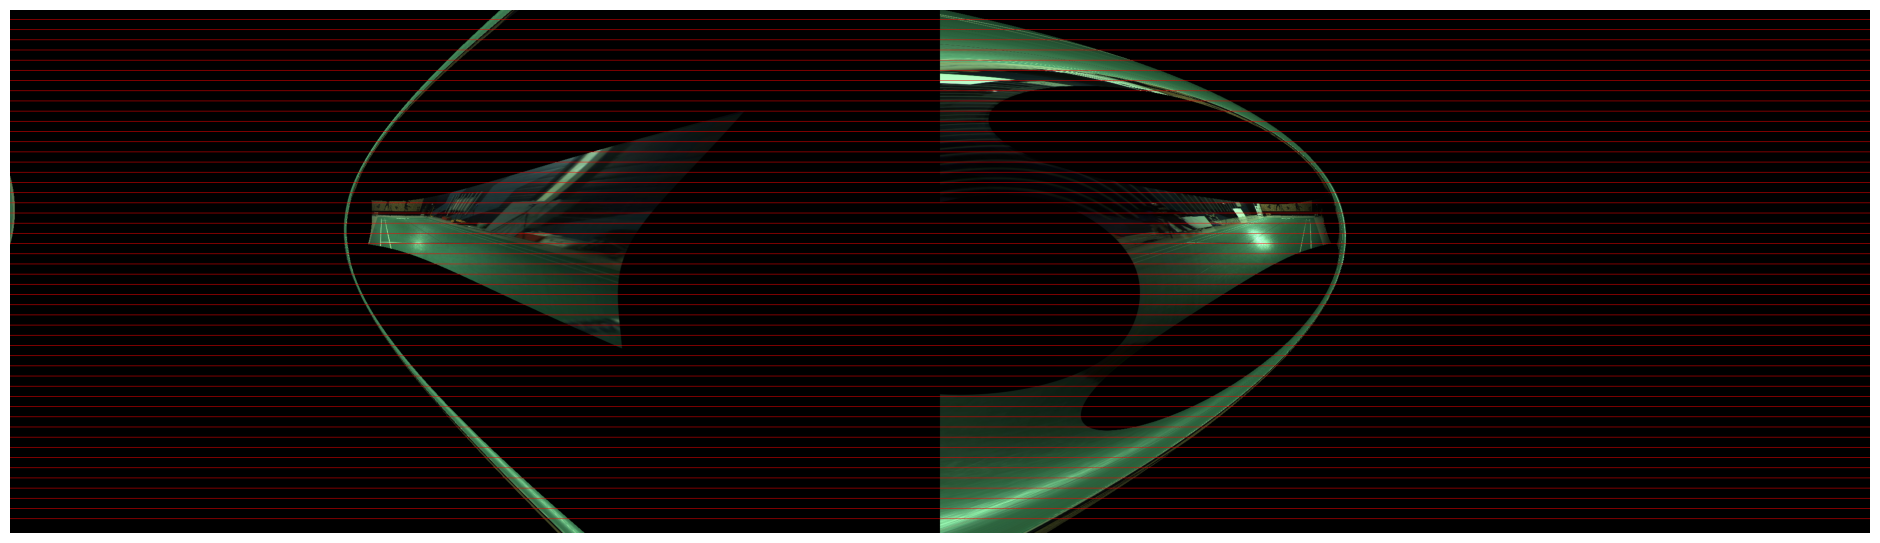

In [52]:
import os

map_data = np.load('./20251125_exp1_雙目參數檔/exp1/stereomap_result_1_2_alp1.npz')
left_map_1 = map_data['left_map_1']
left_map_2 = map_data['left_map_2']
right_map_1 = map_data['right_map_1']
right_map_2 = map_data['right_map_2']

left_rectified = cv2.remap(left_img, left_map_1, left_map_2, cv2.INTER_LINEAR)
right_rectified = cv2.remap(right_img, right_map_1, right_map_2, cv2.INTER_LINEAR)

# === 儲存校正後影像(可指定含中文的絕對路徑) ===
def save_image_with_chinese_path(image, path):
    # 支援含有中文路徑的儲存（OpenCV不直接支援，所以需轉成bytes寫入）
    ext = os.path.splitext(path)[-1].lower()
    if ext in ('.jpg', '.jpeg'):
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 95]
    elif ext == '.png':
        encode_param = [int(cv2.IMWRITE_PNG_COMPRESSION), 3]
    else:
        encode_param = []
    result, encimg = cv2.imencode(ext, image, encode_param)
    if result:
        with open(path, mode='wb') as f:
            encimg.tofile(f)
    else:
        raise RuntimeError(f"影像儲存失敗：{path}")

# 可以修改成你的路徑（支援絕對路徑，以及含有中文的資料夾/檔案名稱）
output_left_path = r'C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20251125_exp1_校正後圖片\exp1\left_rectified_alp1.png'
output_right_path = r'C:\Users\f1410\Desktop\defensive_gap-develop@calibration\3D_coordinate\20251125_exp1_校正後圖片\exp1\right_rectified_alp1.png'
save_image_with_chinese_path(left_rectified, output_left_path)
save_image_with_chinese_path(right_rectified, output_right_path)

# stacked_img = np.hstack((left_rectified, right_rectified)) if (left_rectified is not None and right_rectified is not None) else None

h_combined = np.hstack((left_rectified, right_rectified))
# 在 h_combined 上劃數條基線（以等距方式）
num_lines = 50  # 欲畫基線條數，可依需求調整
h, w, _ = h_combined.shape
line_interval = h // (num_lines + 1)

h_with_lines = h_combined.copy()
line_color = (0, 0, 255)  # 紅色，BGR
thickness = 1

for i in range(1, num_lines + 1):
    y = i * line_interval
    cv2.line(h_with_lines, (0, y), (w-1, y), line_color, thickness)

h_combined = h_with_lines  # 之後顯示可直接用 h_combined

import matplotlib.pyplot as plt
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(right_rectified, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(h_combined, cv2.COLOR_BGR2RGB))
plt.axis('off')


In [ ]:
# --- 載入立體校正 map 並執行影像校正 ---
map_data = np.load('./20251125_exp1_雙目參數檔/exp1/stereomap_result_1_2_alp1.npz')
left_rectified = cv2.remap(left_img, map_data['left_map_1'], map_data['left_map_2'], cv2.INTER_LINEAR)
right_rectified = cv2.remap(right_img, map_data['right_map_1'], map_data['right_map_2'], cv2.INTER_LINEAR)

# --- ROI 交集裁切 ---
x1, y1, w1, h1 = roi1
x2, y2, w2, h2 = roi2
common_y = max(y1, y2)
common_h = max(0, min(y1 + h1, y2 + h2) - common_y)
common_w = min(w1, w2)
left_valid = x1 >= 0 and (x1 + common_w) <= left_rectified.shape[1] and common_y >= y1 and (common_y + common_h) <= y1 + h1
right_valid = x2 >= 0 and (x2 + common_w) <= right_rectified.shape[1] and common_y >= y2 and (common_y + common_h) <= y2 + h2

left_rect_cropped = right_rect_cropped = None
if common_w > 0 and common_h > 0 and left_valid and right_valid:
    left_rect_cropped = left_rectified[common_y:common_y+common_h, x1:x1+common_w]
    right_rect_cropped = right_rectified[common_y:common_y+common_h, x2:x2+common_w]

# --- 合成影像 (for visual inspection or saving) ---
stacked_img = np.hstack((left_rect_cropped, right_rect_cropped)) if (left_rect_cropped is not None and right_rect_cropped is not None) else None
origin_stacked_img = np.hstack((left_rectified, right_rectified))

import os
def imwrite_unicode(file_path, img):
    ext = '.' + file_path.split('.')[-1]
    result, n = cv2.imencode(ext, img)
    if result:
        n.tofile(file_path)
        return True
    return False

def save_image(image, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    imwrite_unicode(path, image)

# --- 圖片儲存路徑 ---
save_dir = './20251125_exp1_校正後圖片/court/output_images/'
save_image(right_rectified, os.path.join(save_dir, 'rectified_R.png'))
save_image(left_rectified, os.path.join(save_dir, 'rectified_L.png'))
if right_rect_cropped is not None:
    save_image(right_rect_cropped, os.path.join(save_dir, 'rect_cropped_R.png'))
if left_rect_cropped is not None:
    save_image(left_rect_cropped, os.path.join(save_dir, 'rect_cropped_L.png'))
if stacked_img is not None:
    save_image(stacked_img, os.path.join(save_dir, 'stacked_img.png'))

import matplotlib.pyplot as plt
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(right_rectified, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB)); plt.axis('off')
if right_rect_cropped is not None:
    plt.figure(figsize=(24, 12))
    plt.imshow(cv2.cvtColor(right_rect_cropped, cv2.COLOR_BGR2RGB)); plt.axis('off')
if left_rect_cropped is not None:
    plt.figure(figsize=(24, 12))
    plt.imshow(cv2.cvtColor(left_rect_cropped, cv2.COLOR_BGR2RGB)); plt.axis('off')
if stacked_img is not None:
    plt.figure(figsize=(24, 12))
    plt.imshow(cv2.cvtColor(stacked_img, cv2.COLOR_BGR2RGB)); plt.axis('off')
if origin_stacked_img is not None:
    plt.figure(figsize=(24, 12))
    plt.imshow(cv2.cvtColor(origin_stacked_img, cv2.COLOR_BGR2RGB)); plt.axis('off')


## 計算視差圖

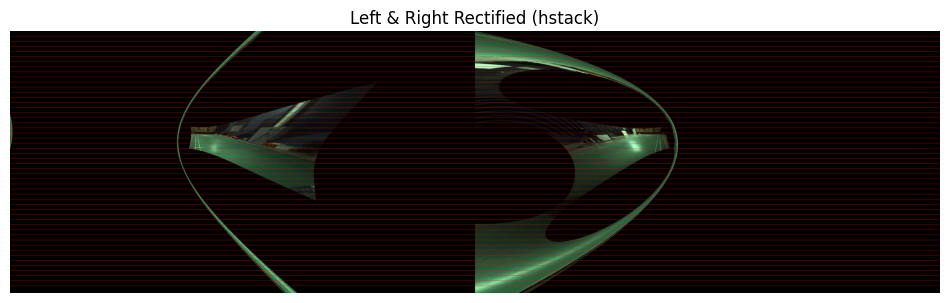

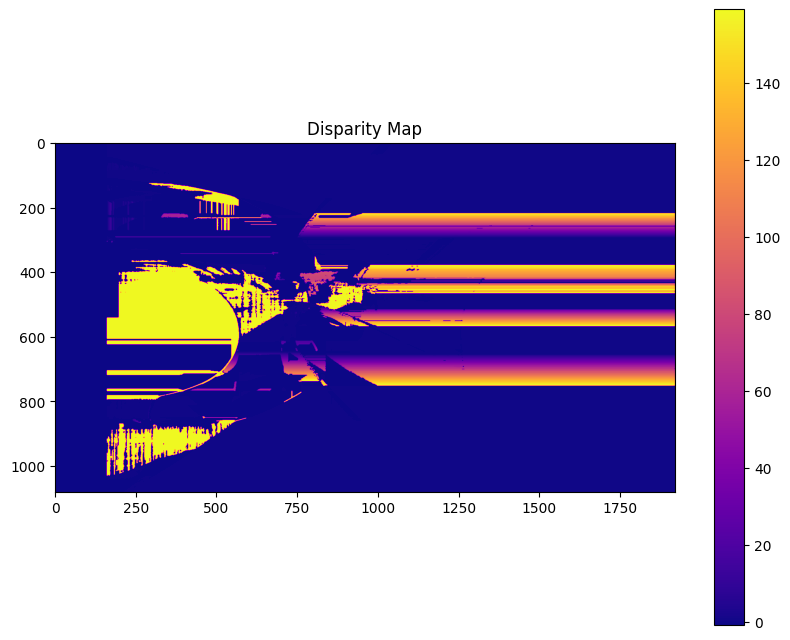

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 設定 SGBM 參數
window_size = 5
min_disp = 0
num_disp = 16 * 10

stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,     # 最小視差值
    numDisparities = num_disp,   # 視差搜尋的範圍長度
    blockSize = window_size,     # window_size
    P1 = 8 * 3 * window_size**2,
    P2 = 32 * 3 * window_size**2,
    disp12MaxDiff = 5,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32,
    preFilterCap = 63,
    mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# 計算視差圖
grayL = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)
disparity = stereo.compute(grayL, grayR).astype(np.float32) / 16.0

# 儲存 disparity csv
pd.DataFrame(disparity).to_csv("disparity_exp1_alp1_v2.csv", index=False, header=False)

# 顯示左右裁切後影像 hstack，加上水平基線
h_combined = np.hstack((left_rectified, right_rectified))
num_lines = 50
h, w, _ = h_combined.shape
line_interval = h // (num_lines + 1)
for i in range(1, num_lines + 1):
    y = i * line_interval
    cv2.line(h_combined, (0, y), (w-1, y), (0, 0, 255), 1)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(h_combined, cv2.COLOR_BGR2RGB))
plt.title('Left & Right Rectified (hstack)')
plt.axis('off')
plt.show()

# 顯示 Disparity Map
plt.figure(figsize=(10, 8))
plt.imshow(disparity, cmap='plasma')
plt.colorbar()
plt.title('Disparity Map')
plt.show()


## 座標系統原點說明

使用 `cv2.reprojectImageTo3D(disparity, Q)` 重建後的 3D 座標系統：

**原點位置：左相機的光心（Optical Center）**

座標軸定義（右手座標系統）：
- **X 軸**：向右（在影像平面，指向右相機方向）
- **Y 軸**：向下（在影像平面）
- **Z 軸**：向前（指向場景，深度方向，與相機光軸平行）

**重要說明：**
1. 這是**校正後的座標系統**，經過 `stereoRectify` 處理
2. 原點固定在左相機的光心位置
3. 座標系統已經旋轉，使得兩個相機的視場平行（極線水平對齊）
4. Z 值表示深度（距離左相機光心的距離），單位與標定時使用的單位相同（通常是米）

**驗證方法：**
- 影像座標 (cx, cy) 對應的 3D 點應該接近 (0, 0, 某個深度值)
- 因為 Q 矩陣中的 -cx 和 -cy 會將主點座標轉換為原點

## 重投影至3D 空間

In [54]:
Q = data['Q']
print(Q)

# [ 1 0 0 -cx ]
# [ 0 1 0 -cy ]
# [ 0 0 0  f  ]
# [ 0 0 1/fx 0]

# 原點：左相機光心
# X 軸：向右（指向右相機）
# Y 軸：向下
# Z 軸：向前（深度方向）


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -7.61304510e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -4.50547951e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.31396194e+03]
 [ 0.00000000e+00  0.00000000e+00  1.66181649e-01 -0.00000000e+00]]


In [55]:
import cv2
import numpy as np

# 每次執行時都要重新從原圖獲取乾淨副本，避免紅點殘留
img_left = left_rectified.copy()
img_right = right_rectified.copy()

if img_left is None or img_right is None:
    print("讀取圖片失敗！請確認路徑正確。")
else:
    clicked_points = []

    def mouse_callback(event, x, y, flags, param):
        # (新增) 先畫主圖和紅點
        img_temp = left_rectified.copy()
        for pt in clicked_points:
            cv2.circle(img_temp, pt, 6, (0, 0, 255), -1)
        # 實時顯示已點擊紅點
        cv2.imshow("Left Image - 點擊紅點", img_temp)

        # --- 放大鏡功能 ---
        magnifier_size = 50   # 原圖區塊半徑(像素) -> 放大鏡視窗大小會是 2*size x 2*size
        zoom = 4              # 放大倍率
        mag_w = mag_h = magnifier_size*2

        # 計算放大鏡區塊範圍
        x1 = max(0, x-magnifier_size)
        y1 = max(0, y-magnifier_size)
        x2 = min(img_temp.shape[1], x+magnifier_size)
        y2 = min(img_temp.shape[0], y+magnifier_size)
        # 裁切區塊
        mag_block = img_temp[y1:y2, x1:x2]
        if mag_block.size > 0:
            mag_block = cv2.resize(mag_block, (mag_block.shape[1]*zoom, mag_block.shape[0]*zoom), interpolation=cv2.INTER_NEAREST)
            # 把當前滑鼠位置畫個框
            cx = (x - x1) * zoom
            cy = (y - y1) * zoom
            cv2.drawMarker(mag_block, (cx, cy), (0,255,0), markerType=cv2.MARKER_CROSS, markerSize=15, thickness=2)
            cv2.imshow("Magnifier", mag_block)
        
        if event == cv2.EVENT_LBUTTONDOWN:
            clicked_points.append((x, y))
            # 每次顯示都從 left_rectified 原圖 copy，畫所有目前已點擊的點，這樣不會留下舊痕跡
            img_temp = left_rectified.copy()
            for pt in clicked_points:
                cv2.circle(img_temp, pt, 6, (0, 0, 255), -1)
            cv2.imshow("Left Image - 點擊紅點", img_temp)

    print("請用滑鼠左鍵在彈出的 left_rectified 視窗點選目標位置，點完所有點後請關閉視窗（按任意鍵）.")

    # 初始內容亦應是不帶紅點的原圖
    cv2.imshow("Left Image - 點擊紅點", img_left)
    cv2.setMouseCallback("Left Image - 點擊紅點", mouse_callback)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    print("所有點擊的像素座標：")
    for idx, pt in enumerate(clicked_points, 1):
        print(f"{idx}: {pt}")

    # left_rectified+紅點圖（僅這一步才畫點留存結果，前面互動過程皆不會污染原圖）
    img_left_with_points = left_rectified.copy()
    for (x, y) in clicked_points:
        cv2.circle(img_left_with_points, (x, y), 6, (0, 0, 255), -1)

    # right_rectified+視差對應點圖
    img_right_with_points = right_rectified.copy()
    for (x, y) in clicked_points:
        # 安全檢查
        if 0 <= y < disparity.shape[0] and 0 <= x < disparity.shape[1]:
            d = disparity[y-1, x-1]
            print(f"d={d}")
            if d > 0:
                xr = int(round(x - d))
                if 0 <= xr < img_right_with_points.shape[1]:
                    # 在右圖標上對應點
                    cv2.circle(img_right_with_points, (xr, y), 6, (255, 0, 0), -1)
    # 顯示左圖
    cv2.imshow("Left Rectified with Points", img_left_with_points)
    # 顯示右圖
    cv2.imshow("Right Rectified with Correspondence", img_right_with_points)
    print("請檢查彈出的兩張圖。按任意鍵關閉所有視窗。")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

請用滑鼠左鍵在彈出的 left_rectified 視窗點選目標位置，點完所有點後請關閉視窗（按任意鍵）.
所有點擊的像素座標：
1: (1028, 482)
2: (1008, 483)
3: (892, 483)
4: (784, 480)
5: (764, 480)
d=-1.0
d=-1.0
d=159.0
d=-1.0
d=149.6875
請檢查彈出的兩張圖。按任意鍵關閉所有視窗。


In [47]:
print(clicked_points)
(x1, y1)  = clicked_points[0]
(x2, y2)  = clicked_points[1]
# (x3, y3)  = clicked_points[2]
# (x4, y4)  = clicked_points[3]
# (x5, y5)  = clicked_points[4]
# (x6, y6)  = clicked_points[5]
# (x7, y7)  = clicked_points[6]

[(1442, 273), (1381, 233)]


In [ ]:
# image_path = input("請輸入圖片路徑：")
img = left_rectified
if img is None:
    print("讀取圖片失敗！請確認路徑正確。")
else:
    clicked_points = []

    # --- 加入放大鏡功能 ---
    import numpy as np

    magnifier_size = 80  # 放大鏡視窗邊長
    magnifier_scale = 3  # 放大倍率
    magnifier_window = "Magnifier"

    def show_magnifier(img, x, y, winname=magnifier_window):
        h, w = img.shape[:2]
        half = magnifier_size // 2
        # 計算ROI區域（注意邊界）
        x1, x2 = max(0, x-half), min(w, x+half)
        y1, y2 = max(0, y-half), min(h, y+half)
        roi = img[y1:y2, x1:x2]
        if roi.size == 0:
            return
        roi_zoom = cv2.resize(roi, (magnifier_size*magnifier_scale, magnifier_size*magnifier_scale),
                              interpolation=cv2.INTER_NEAREST)
        # 畫中心藍色十字
        center = magnifier_size * magnifier_scale // 2
        cv2.drawMarker(roi_zoom, (center, center), (255,0,0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)
        cv2.imshow(winname, roi_zoom)

    def mouse_callback(event, x, y, flags, param):
        global img   # 若你在其他程式片段有img = img.copy()可省略
        if event == cv2.EVENT_MOUSEMOVE:
            show_magnifier(img, x, y)
        if event == cv2.EVENT_LBUTTONDOWN:
            cv2.circle(img, (x, y), 2, (0, 0, 255), -1)
            clicked_points.append((x, y))
            cv2.imshow("Image", img)
            show_magnifier(img, x, y)

    print("請用滑鼠左鍵點擊目標位置，滑鼠移動時右側顯示放大鏡，按下任意鍵結束。")
    cv2.imshow("Image", img)
    cv2.setMouseCallback("Image", mouse_callback)
    # 初始化放大鏡位置在圖中央
    ch, cw = img.shape[0]//2, img.shape[1]//2
    show_magnifier(img, cw, ch)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

    print("所有點擊的像素座標：")
    for idx, pt in enumerate(clicked_points, 1):
        print(f"{idx}: {pt}")

# 擷取前15個點並個別存成參數 (x1, y1), (x2, y2), ..., (x15, y15)
if len(clicked_points) < 15:
    raise ValueError("你必須點擊至少2個點！")
(x1, y1)  = clicked_points[0]
(x2, y2)  = clicked_points[1]
(x3, y3)  = clicked_points[2]
(x4, y4)  = clicked_points[3]
(x5, y5)  = clicked_points[4]
(x6, y6)  = clicked_points[5]
(x7, y7)  = clicked_points[6]
(x8, y8)  = clicked_points[7]
(x9, y9)  = clicked_points[8]
(x10, y10) = clicked_points[9]
(x11, y11) = clicked_points[10]
(x12, y12) = clicked_points[11]
(x13, y13) = clicked_points[12]
(x14, y14) = clicked_points[13]
(x15, y15) = clicked_points[14]


請用滑鼠左鍵點擊目標位置，滑鼠移動時右側顯示放大鏡，按下任意鍵結束。


所有點擊的像素座標：
1: (1443, 274)
2: (1383, 233)


In [43]:
# 重建 3D 點雲
print('正在重建 3D 座標...')
points_3d = cv2.reprojectImageTo3D(disparity, Q)
# print(points_3d)

# points_3d 是一個形狀為 (height, width, 3) 的陣列
# points_3d[y, x] 包含了該像素點的 (X, Y, Z) 座標

# 1. 獲取該點的視差值
# 計算15個點的3D座標
# (x4, y4), (x5, y5), (x6, y6), (x7, y7), (x8, y8), (x9, y9), (x10, y10), (x11, y11), (x12, y12), (x13, y13), (x14, y14), (x15, y15)
points_2d = [(x1, y1), (x2, y2), (x3,y3), (x4, y4), (x5, y5), (x6, y6), (x7, y7)]
points_3d_list = []
for idx, (x, y) in enumerate(points_2d, 1):
    # OpenCV的座標(y, x)
    d = disparity[y-4, x]
    print(f"第{idx}點 ({x}, {y}) 的視差d = {d}")
    if d > 0:
        pt3d = points_3d[y, x]
        points_3d_list.append(pt3d)
        print(f"第{idx}點的 3D 座標為: X={pt3d[0]:.2f}, Y={pt3d[1]:.2f}, Z={pt3d[2]:.2f}")
    else:
        points_3d_list.append(None)
        print(f"第{idx}點視差無效 (可能是遮蔽或紋理不足)")

正在重建 3D 座標...
第1點 (1210, 211) 的視差d = -1.0
第1點視差無效 (可能是遮蔽或紋理不足)
第2點 (1254, 210) 的視差d = 155.0
第2點的 3D 座標為: X=-2964.80, Y=1447.50, Z=-7906.78
第3點 (1288, 210) 的視差d = -1.0
第3點視差無效 (可能是遮蔽或紋理不足)
第4點 (1333, 217) 的視差d = -1.0
第4點視差無效 (可能是遮蔽或紋理不足)
第5點 (1367, 216) 的視差d = -1.0
第5點視差無效 (可能是遮蔽或紋理不足)
第6點 (1390, 214) 的視差d = -1.0
第6點視差無效 (可能是遮蔽或紋理不足)
第7點 (1469, 215) 的視差d = -1.0
第7點視差無效 (可能是遮蔽或紋理不足)
